<a href="https://colab.research.google.com/github/tinamliang/face_mask_detector/blob/main/face_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O a3_face_dataset.tar.gz https://www.dropbox.com/sh/20zrofhd10f3dev/AABNeF9__K6JKJ-it_eYTYLLa/mask-detection/images?dl=0&subfolder_nav_tracking=1

--2022-03-12 19:52:46--  https://www.dropbox.com/sh/20zrofhd10f3dev/AABNeF9__K6JKJ-it_eYTYLLa/mask-detection/images?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/20zrofhd10f3dev/AABNeF9__K6JKJ-it_eYTYLLa/mask-detection/images [following]
--2022-03-12 19:52:46--  https://www.dropbox.com/sh/raw/20zrofhd10f3dev/AABNeF9__K6JKJ-it_eYTYLLa/mask-detection/images
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc73f442400df6242ad90a12d273.dl.dropboxusercontent.com/zip_download_get/BEv2BxEc3eWvO8d5B7zCufInpmjgwBv6wvAbI9pl-HxepdPhsN6x4G3R8e8NWAZksvJiXTR6PaPsI8-wq7y1a5IJT_xYJimqJLghNkRH193Haw# [following]
--2022-03-12 19:52:47--  https://uc73f442400df6242ad90a12d273.dl.dropboxusercontent.com/zip_download_get/BEv2BxEc3eW

In [ ]:
!unzip a3_face_dataset.tar.gz

Archive:  a3_face_dataset.tar.gz
mapname:  conversion of  failed
   creating: val/
   creating: test/
   creating: train/
   creating: val/with_mask/
   creating: test/with_mask/
   creating: train/with_mask/
   creating: val/without_mask/
   creating: test/without_mask/
   creating: train/without_mask/
 extracting: val/with_mask/train_00024697.jpg  
 extracting: val/with_mask/train_00024696.jpg  
 extracting: val/with_mask/train_00024695.jpg  
 extracting: val/with_mask/train_00024694.jpg  
 extracting: val/with_mask/train_00024693.jpg  
 extracting: val/with_mask/train_00024692.jpg  
 extracting: val/with_mask/train_00024691.jpg  
 extracting: val/with_mask/train_00024690.jpg  
 extracting: val/with_mask/train_00024689.jpg  
 extracting: val/with_mask/train_00024688.jpg  
 extracting: val/with_mask/train_00024687.jpg  
 extracting: val/with_mask/train_00024686.jpg  
 extracting: val/with_mask/train_00024685.jpg  
 extracting: val/with_mask/train_00024684.jpg  
 extracting: val/with_m

In [ ]:
import tensorflow as tf
!pip install keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image

In [ ]:
import glob
import matplotlib.pyplot as plt
from IPython.display import display, Image
import os
# Display the first images from the dataset. You can also browse these by
# # navigating through the notebook's file system!
# sample_images = glob.glob('train/without_mask/*.jpg')[:5]
# for file_path in sample_images:
#   display(Image(file_path))

print('Train images with mask -', len(os.listdir(
  'train/with_mask')))
print('Train images without mask -', len(os.listdir(
    'train/without_mask')))
print('Total train images -', len(os.listdir(
  'train/with_mask')) +
     len(os.listdir(
    'train/without_mask')))

Train images with mask - 600
Train images without mask - 600
Total train images - 1200


In [ ]:
print('Test images with mask -', len(os.listdir(
  'test/with_mask')))
print('Test images without mask -', len(os.listdir(
    'test/without_mask')))
print('Test train images -', len(os.listdir(
  'test/with_mask')) +
     len(os.listdir(
    'test/without_mask')))

Test images with mask - 100
Test images without mask - 100
Test train images - 200


In [ ]:
print('Validation images with mask -', len(os.listdir(
  'val/with_mask')))
print('Validation images without mask -', len(os.listdir(
    'val/without_mask')))
print('Total validation images -', len(os.listdir(
  'val/with_mask')) +
     len(os.listdir(
    'val/without_mask')))

Validation images with mask - 300
Validation images without mask - 300
Total validation images - 600


In [ ]:
batch_size = 64
epochs = 20
img_h = 150
img_w = 150
img_channels = 3


In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2,
                                         rotation_range=0.2)

validation_image_generator = ImageDataGenerator(rescale=1./255,
                                         zoom_range=0.2,
                                         shear_range=0.2,
                                         rotation_range=0.2)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory= 'train/',
                                                           shuffle=True, 
                                                           target_size=(img_h, img_w),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory='val/',
                                                              target_size=(img_h, img_w),
                                                              class_mode='binary')

Found 1200 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


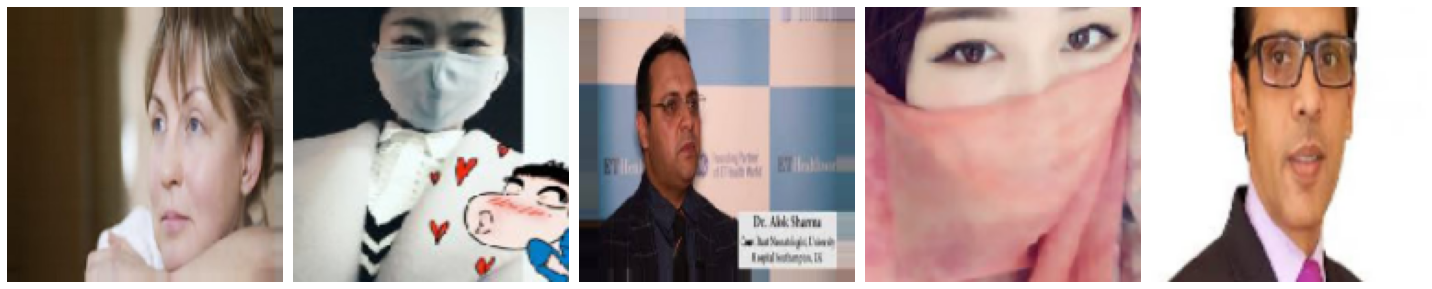

In [ ]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
model = Sequential([
 Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_h, img_w , img_channels)),
 MaxPooling2D(),
 Conv2D(32, 3, padding='same', activation='relu'),
 MaxPooling2D(),
 Conv2D(64, 3, padding='same', activation='relu'),
 MaxPooling2D(),
 Flatten(),
 Dense(512, activation='relu'),
 Dense(1)])

In [ ]:
model.compile(optimizer='adam',
 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
 metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [ ]:
num_withmask_tr = len(os.listdir("train/with_mask"))
num_withoutmask_tr = len(os.listdir("train/without_mask"))
num_withmask_val = len(os.listdir("test/with_mask"))
num_withoutmask_val = len(os.listdir("test/without_mask"))
total_train = num_withmask_tr + num_withoutmask_tr
total_val = num_withmask_val + num_withoutmask_val

In [ ]:
history = model.fit_generator(
 train_data_gen,
 steps_per_epoch=total_train // batch_size,
 epochs=epochs,
 validation_data=val_data_gen,
 validation_steps=total_val // batch_size
)

Epoch 1/20
18/18 [==============================] - 42s 2s/step - loss: 1.3163 - accuracy: 0.4912 - val_loss: 0.6856 - val_accuracy: 0.5000
Epoch 2/20
18/18 [==============================] - 41s 2s/step - loss: 0.6466 - accuracy: 0.5379 - val_loss: 0.5894 - val_accuracy: 0.5677
Epoch 3/20
18/18 [==============================] - 40s 2s/step - loss: 0.4973 - accuracy: 0.7518 - val_loss: 0.5301 - val_accuracy: 0.7448
Epoch 4/20
18/18 [==============================] - 40s 2s/step - loss: 0.4344 - accuracy: 0.8037 - val_loss: 0.4557 - val_accuracy: 0.7604
Epoch 5/20
18/18 [==============================] - 40s 2s/step - loss: 0.4061 - accuracy: 0.8222 - val_loss: 0.4500 - val_accuracy: 0.8021
Epoch 6/20
18/18 [==============================] - 40s 2s/step - loss: 0.3774 - accuracy: 0.8371 - val_loss: 0.4122 - val_accuracy: 0.8281
Epoch 7/20
18/18 [==============================] - 40s 2s/step - loss: 0.3632 - accuracy: 0.8342 - val_loss: 0.3847 - val_accuracy: 0.8333
Epoch 8/20
18/18 [==

In [ ]:
loss, accuracy = model.evaluate(train_data_gen)

19/19 [==============================] - 20s 1s/step - loss: 0.1638 - accuracy: 0.9317


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:             
     json_file.write(model_json) 

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

def plot_acc_loss(acc, val_acc, loss, val_loss):
    epochs = range(1, len(acc) + 1)

  # Accuracy Plot
    plt.plot(epochs, acc, 'bo', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and Validation Acc')
    plt.legend()

    plt.figure()

  # Loss Plot
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
  
    plt.show()

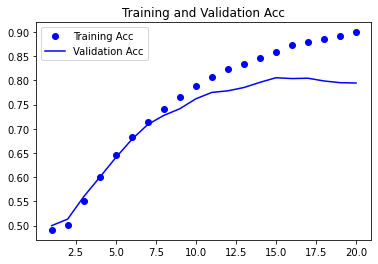

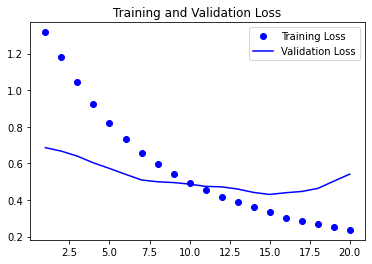

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plot_acc_loss(smooth_curve(acc),
              smooth_curve(val_acc),
              smooth_curve(loss),
              smooth_curve(val_loss))